In [1]:
# Base algo is fromn Suttons book: http://www.incompleteideas.net/book/the-book.html section 7.2 (in 2020 version)

# Inspired by https://www.youtube.com/watch?v=77m1j2qYPRg.. ie the tabular tuning is just out right stolen from him

# *BUT* this isnt quite N-step-sarsa. I unraveled the update code so its saner than suttons t - n + 1 WTF.. 
# and added a minor improvement to the algo that used the game end reward inplace of q value

In [2]:
%matplotlib inline

In [3]:
import gym
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [20, 10]

In [4]:
def setup_state(binCount = 11):    
    # there are n-1 boarders between n bins
    bins = np.array([
        np.linspace(-2.4, 2.4,     binCount-1),  # cart position 
        np.linspace(-4, 4,         binCount-1),  # cart speed
        np.linspace(-0.209, 0.209, binCount-1),  # pole angle
        np.linspace(-4, 4,         binCount-1)   # pole speed
    ])
    
    # returns an approximate observation tuple
    def make_obs(values):
        return tuple([bins[i,v-1] if v > 0 else -np.inf for i,v in enumerate(values)])
    
    # returns an state tuple
    def make_state(values):
        return tuple([np.digitize(v,bins[i]) for i,v in enumerate(values)])
    
    return make_state, make_obs, bins

In [5]:
make_state, make_obs, bins = setup_state()

In [6]:
# tests
vs = [
    (0.1,-2.423, 1.3, -2.1),
    (-np.inf,-np.inf, -np.inf, -np.inf),
    (np.inf,np.inf,np.inf,np.inf)
]

for v in vs:
    s = make_state(v)
    v2 = make_obs(s)
    s2 = make_state(v2)

    if s != s2: 
        print("FAIL:", v,s,v2,s2)
    else:
        print("pass:", v,s,v2,s2)
     

pass: (0.1, -2.423, 1.3, -2.1) (5, 2, 10, 3) (-0.2666666666666666, -3.111111111111111, 0.209, -2.2222222222222223) (5, 2, 10, 3)
pass: (-inf, -inf, -inf, -inf) (0, 0, 0, 0) (-inf, -inf, -inf, -inf) (0, 0, 0, 0)
pass: (inf, inf, inf, inf) (10, 10, 10, 10) (2.4, 4.0, 0.209, 4.0) (10, 10, 10, 10)


In [7]:
# returns an action tuple
def choose_action(q_values, 
                  state, 
                  exploration_ratio=0.1, 
                  rand=np.random.rand):    
    if rand() < exploration_ratio:
        action_count = q_values.shape[-1]
        action = (int(rand() * action_count),)
        return action, q_values[state + action]
    
    action = (np.argmax(q_values[state]),)
    return action, q_values[state + action]

In [8]:
# test
q_shape = (11,11,11,11,2)
q = np.arange(np.prod(q_shape)).reshape(q_shape)

state = (1,2,3,4)

a, q_value = choose_action(q, state, rand=lambda: 0.9)

if a != (1,): 
    print("FAIL:", q[state],a, q_value)
else:
    print("pass:", q[state],a, q_value)

# reverse the q array
q = q[:,:,:,:,::-1]
print()

a, q_value = choose_action(q, state, rand=lambda: 0.9)

if a != (0,): 
    print("FAIL:", q[state],a, q_value)
else:
    print("pass:", q[state],a, q_value)

pass: [3220 3221] (1,) 3221

pass: [3221 3220] (0,) 3221


In [54]:
def train(alpha = 0.1,
          gamma = 0.9,
          n=16,
          episodes=50000,
          env_reset=None,
          env_step =None,
          epsilion =None):

    # TODO clean this mess up
    q_value_shape = (11,11,11,11,2)
    q_state_count = 4
    action_count  = 1

    # precalcuate discount rates
    gamma_constants = np.power(gamma,np.arange(n)) 

    # reset expected values
    q_values = np.zeros(q_value_shape)

    # track metric (sum of rewards)
    scores = []
    
    # track n-steps 
    memory_states  = np.array([None for i in range(n)], dtype=object)
    memory_actions = np.array([None for i in range(n)], dtype=object)
    memory_rewards = np.zeros(n)
    
    for i in range(episodes):
        # setup for new game
        end_t = np.inf
        t     = 0
        score = 0
        eps   = epsilion(i)
        
        observation = env_reset()
        
        # we play the game utill it terminates but we have to update the last n time slots            
        while t < end_t + n:
            
            if t < end_t:
                # we play the game until the end. Which we assume is infinite until actually found
                memory_idx = t % n
                
                # decide the state from what we can see, 
                q_state = make_state(observation)
                # choose the action (and get its expected reward) 
                
                action, q_value = choose_action(q_values, q_state, exploration_ratio=eps)
                # check the actions result and what we can see next
                observation, reward, done = env_step(action)
                
                # record the state, action and reward
                memory_states [memory_idx] = q_state
                memory_actions[memory_idx] = action
                memory_rewards[memory_idx] = reward 
                
                score += reward
                
                # set end time if found
                if done:
                    end_t = t
         
            if t >= n:
                # once we have enough reards we start updating at the point -n steps 
                # back in time.
                
                # we use with n-1 rewards into the future and
                # the q value estimating the remaining rewards until end of game 

                # select the n-1 rewards
                update_t_start = t - n 
                update_t_end   = min(t-1, end_t)
                
                # note memory is a circular buffer so we need to straighten it out
                memory_idxs   = np.arange(update_t_start, update_t_end) % n
                gamma_idx_end = update_t_end - update_t_start

                q_value_estimate = np.sum(memory_rewards[memory_idxs] * gamma_constants[:gamma_idx_end])

                # in the case that the game is midway we need an estimate of the
                # remaining rewards after the n known ones until the games end point
                # we use the last know state/actions q value for this estimate
                if t < end_t:                     
                    q_value_estimate += gamma_constants[-1] * q_value
                elif t == end_t:                 
                    # if it is the last step we know the exact reward why use the q_value
                    q_value_estimate += gamma_constants[-1] * memory_rewards[t%n]
                                        
                memory_idx = update_t_start % n
                state  = memory_states [memory_idx]
                action = memory_actions[memory_idx]
                
                q_value_actual = q_values[state + action]
                q_value_actual += alpha*(q_value_estimate - q_value_actual)
                q_values[state + action] = q_value_actual
                
            t += 1 
        
        # save the final score
        scores.append(score)
        
        #scale epsilon (for first 50%)

                
        if i % 1000 == 0:
            print("%d eps:%.3f ave score:%d" % (i, eps,  np.mean(scores[-1000:])))
    return q_values, scores

In [55]:
def make_schedule():
    # i want to go down to 0.0 hold for a few cycles(burn in) and then repeat 
    schedule = []

    total    = 70000
    cycle    = 10000
    reset    = 0.4
    start    = 1.0
    rate1     = 1.5/cycle
    rate2     = reset*1.5/cycle
    
    current  = 1.0
    while len(schedule) < total:
        if len(schedule) < 1:
            current = start
            rate = rate1
        else:
            current = reset
            rate = rate2

        batch = []
        for i in range(cycle):
            
            current -= rate
            if current < 0:
                current = 0
                
            schedule.append(current)
            
    return schedule

In [56]:
schedule = make_schedule()

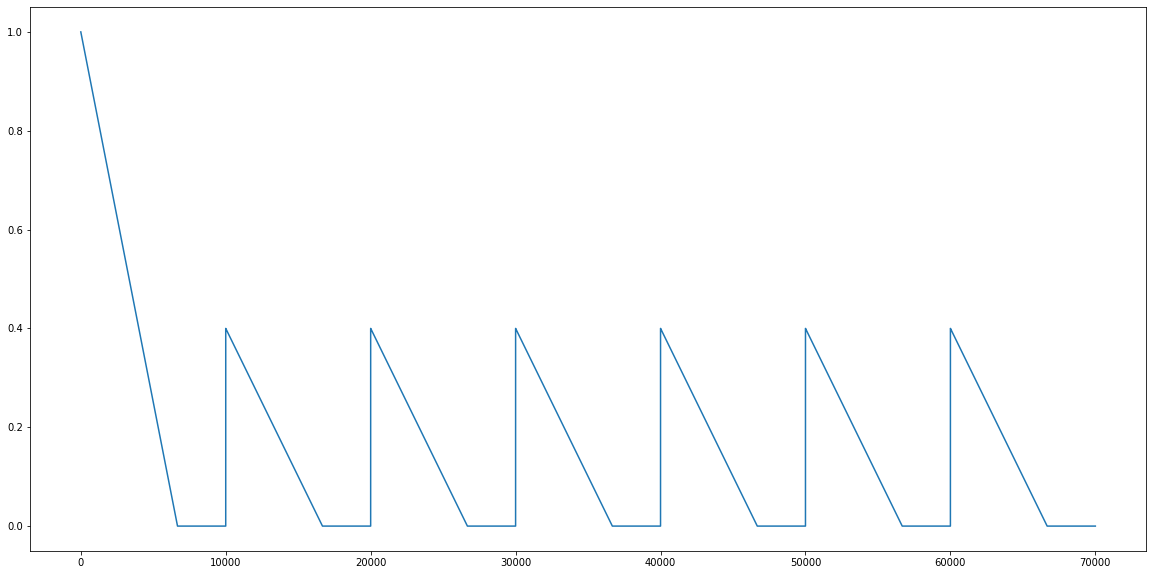

In [57]:
plt.plot(schedule)
plt.show()

In [58]:
# select the game we want to learn

env = gym.make('CartPole-v0')

env_reset = lambda: env.reset()

def env_step(action):
    observation, reward, done, _ = env.step(action[0])
    return (observation, reward, done)

eps_schdeule = lambda i: schedule[i]

In [59]:
%%time
_, scores = train(episodes=70000, env_reset=env_reset, env_step=env_step, epsilion=eps_schdeule)

0 eps:1.000 ave score:15
1000 eps:0.850 ave score:25
2000 eps:0.700 ave score:35
3000 eps:0.550 ave score:58
4000 eps:0.400 ave score:87
5000 eps:0.250 ave score:115
6000 eps:0.100 ave score:138
7000 eps:0.000 ave score:138
8000 eps:0.000 ave score:144
9000 eps:0.000 ave score:145
10000 eps:0.400 ave score:130
11000 eps:0.340 ave score:112
12000 eps:0.280 ave score:122
13000 eps:0.220 ave score:131
14000 eps:0.160 ave score:142
15000 eps:0.100 ave score:141
16000 eps:0.040 ave score:148
17000 eps:0.000 ave score:141
18000 eps:0.000 ave score:143
19000 eps:0.000 ave score:145
20000 eps:0.400 ave score:146
21000 eps:0.340 ave score:119
22000 eps:0.280 ave score:122
23000 eps:0.220 ave score:137
24000 eps:0.160 ave score:142
25000 eps:0.100 ave score:146
26000 eps:0.040 ave score:150
27000 eps:0.000 ave score:141
28000 eps:0.000 ave score:118
29000 eps:0.000 ave score:124
30000 eps:0.400 ave score:143
31000 eps:0.340 ave score:112
32000 eps:0.280 ave score:126
33000 eps:0.220 ave score:13

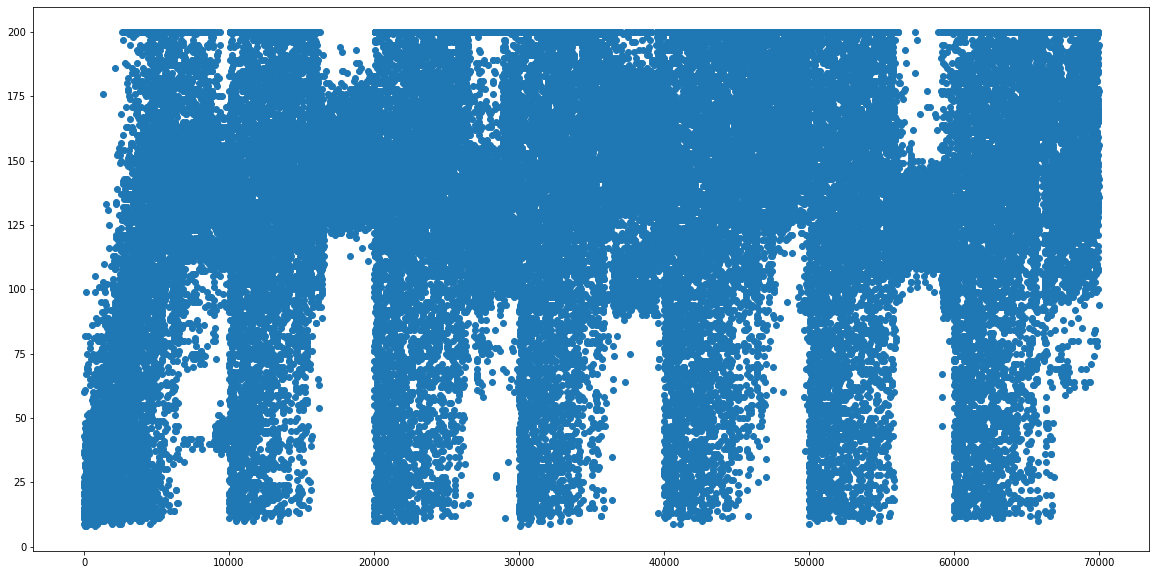

In [60]:
plt.scatter(range(len(scores)), scores)
plt.show()

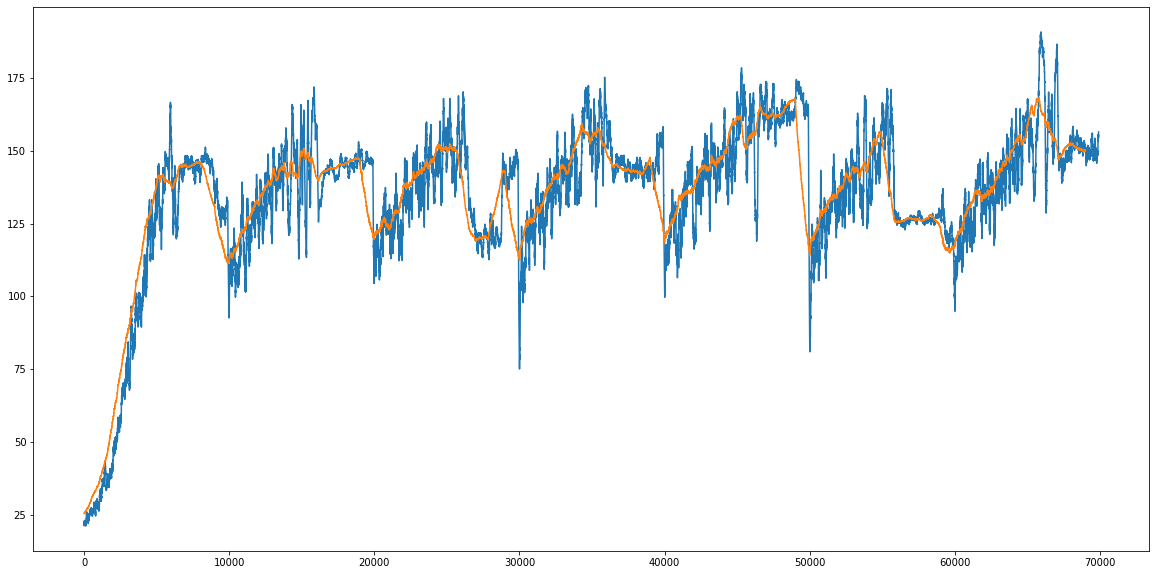

In [61]:
def sliding_ave(x, N): 
    return np.convolve(x, np.ones((N,))/N, mode='valid')

plt.plot(sliding_ave(scores, 100))
plt.plot(sliding_ave(scores, 1000))
plt.show()

In [62]:
import scipy.stats

def denisty_plot(x,
                 y, 
                 line_count=30,
                 alpha=0.1):
    xmin, xmax = np.amin(x), np.amax(x)                                                                           
    ymin, ymax = np.amin(y), np.amax(y)

    def density_estimation(x, y):
        X, Y = np.mgrid[xmin:xmax:50j, ymin:ymax:100j]
        positions = np.vstack([X.ravel(), Y.ravel()])
        values = np.vstack([x, y])
        kernel = scipy.stats.gaussian_kde(values)
        Z = np.reshape(kernel(positions).T, X.shape)
        return X, Y, Z
    
    X, Y, Z = density_estimation(x, y)
    
    zmin, zmax       = np.amin(Z), np.amax(Z)
    
    levels = np.linspace(zmin, zmax, line_count)
    
    plt.scatter(x, y, alpha=alpha, color="grey")
    #CS = plt.contour(X, Y, Z, levels=levels, cmap='copper')
    #CS = plt.contour(X, Y, Z, levels=levels, cmap='gist_rainbow')
    CS = plt.contour(X, Y, Z, levels=levels, cmap='plasma')
    plt.clabel(CS, inline=1, fontsize=10)

    plt.show()

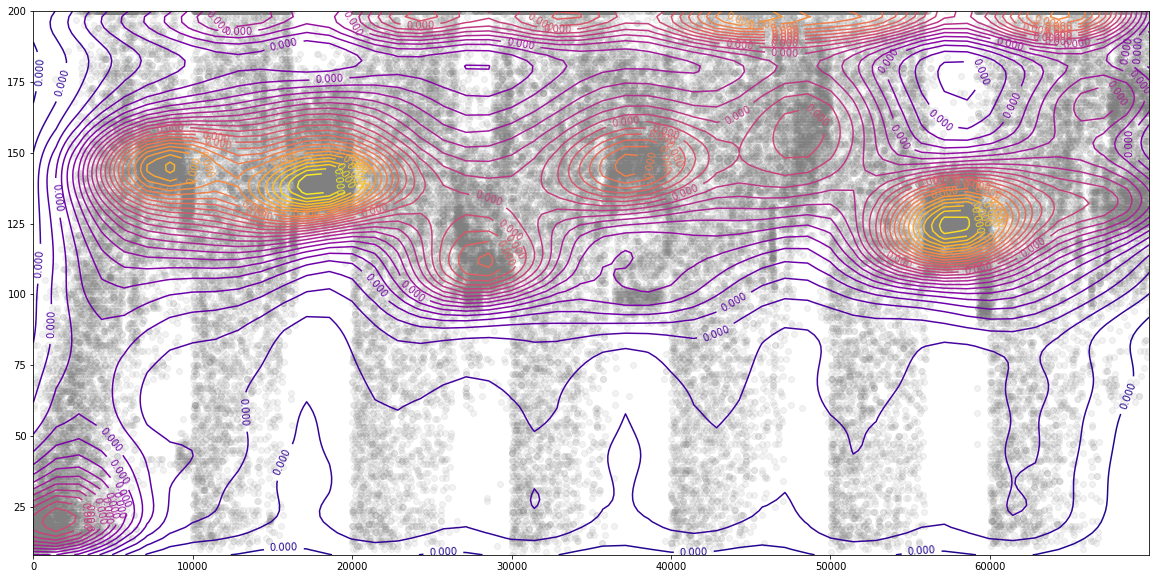

In [63]:
denisty_plot(np.arange(len(scores)),scores)